This is a notebook to test and document the Fresnel integral and attenuation capabilities of the raytracer.

In [7]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gc
import sys


#add path
sys.path.insert(0, '../../')     # import path/to/synthpy
import field_generator.gaussian3D as g3

sys.path.insert(0, '../../synthPy_restructured')
import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
import x_ray_diffraction as xray
import spherical_v2 as sp
import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)


<module 'propagator' from 'c:\\Users\\qinal\\OneDrive - Imperial College London\\UROP\\synthPy\\examples\\notebooks\\../../synthPy_restructured\\propagator.py'>

In [8]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 100

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

print("Garbage collection count:", gc.collect())

domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

Garbage collection count: 278


In [9]:
wl = 0.1e-9 #define laser wavelength

# initialise beam
Np = 100000  # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = 0.9*extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'square'

initial_rays = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction, wl, beam_type)

In [10]:
def density_step(domain, rho1, rho2):
    """
    A density function which has value rho1 for y>0 and rho2 for y<=0
    """
    density = np.zeros_like(domain.YY)
    density[domain.YY > 0] = rho1
    density[domain.YY <= 0] = rho2
    return density


In [11]:
def trace_n_plot(suptitle, titles = ["Phase on", "Phase off"], savefig = False, fname = "hi", rho = None):
    tracer = p.Propagator(domain, initial_rays, inv_brems = False, x_ray = True, phaseshift = True, refrac_field = False, elec_density = True)
    # solve ray trace
    tracer.calc_dndr()
    if domain.spherical is True:
        files = ("opa_DT_NLTE_Full_linear1000.spk", "opa_C_NLTE_Full_linear1000.spk", "opa_CH_NLTE_Full_linear1000.spk")
        sp.spherical_interps(tracer, 3, files, rho)
    tracer.set_up_interps()


    final_rays = tracer.solve(parallelise = True, jitted = True, Nt = 2)
    jones_vector = tracer.Beam.rf
    amplitudes = tracer.Beam.amplitudes
    phases = tracer.Beam.phases

    print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")

    tracer1 = p.Propagator(domain, initial_rays, inv_brems = False, x_ray = True, phaseshift = False, refrac_field = False, elec_density = True)
    tracer1.calc_dndr()
    if domain.spherical is True:
        sp.spherical_interps(tracer1, 3, files, rho)
    tracer1.set_up_interps()
    final_rays1 = tracer1.solve(parallelise = True, jitted = True, Nt = 2)
    jones_vector1 = tracer1.Beam.rf
    amplitudes1 = tracer1.Beam.amplitudes
    phases1 = tracer1.Beam.phases
    print("\nCompleted ray trace in", np.round(tracer1.duration, 3), "seconds.")

    fig, axs = plt.subplots(1,2)
    fig.suptitle(suptitle, y=0.8)
    fig.tight_layout()
    fig.subplots_adjust(wspace = 0.5, top = 0.9)
    axes = axs.flatten()

    final_field = xray.propagate(Propagator = tracer, jones_vector = jones_vector, amplitudes = amplitudes, phases = phases,  z = 0.01, res = 3)
    final_field1 = xray.propagate(Propagator = tracer1, jones_vector = jones_vector1, amplitudes = amplitudes1, phases = phases1,  z = 0.01, res = 3)

    im = axes[0].imshow(np.real(final_field)**2, extent = (-5, 5, -5, 5), cmap = "viridis")
    im1 = axes[1].imshow(np.real(final_field1)**2, extent = (-5, 5, -5, 5), cmap = "viridis")
    images = [im, im1] 
    for i, ax in enumerate(axes):
        ax.set_xlabel("x position (mm)")
        ax.set_ylabel("y position (mm)")
        fig.colorbar(images[i], ax = ax, fraction = .05, pad = 0.2)
        ax.set_title(titles[i])
    if savefig is True:
        plt.savefig(f"../../../{fname}.png",dpi=800, bbox_inches='tight', pad_inches=0.1)

In [ ]:
domain.test_exponential_cos(n_e0 = 1e27, Ly = domain.y_length * 0.25)
domain.external_Te(np.full((n_cells, n_cells, n_cells), 2e3))
domain.external_mass_density(density_step(domain, 1e4, 1e3))
domain.spherical = False

jax compilation of solver took: 0.0011208057403564453

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (10000, 2, 9)
	2 to account the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation

We reshape into the form: (9, 10000)

Completed ray trace in 32.557 seconds.
jax compilation of solver took: 0.0014011859893798828

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (10000, 2, 9)
	2 to account the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation

We reshape into the form: (9, 10000)

Completed ray trace in 25.368 seconds.
Fresnel Number: 100000000.0000
Fresnel Number: 100000000.0000


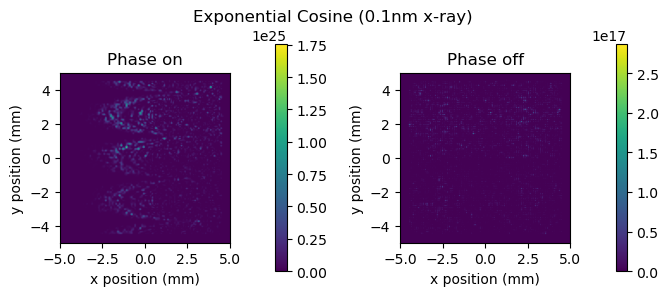

In [8]:
trace_n_plot(suptitle="Exponential Cosine (0.1nm x-ray)")

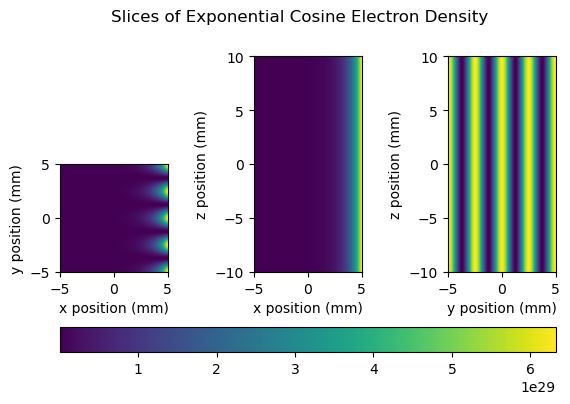

In [ ]:
fig, axs = plt.subplots(1,3)
axs = axs.flatten()
fig.suptitle("Slices of Exponential Cosine Electron Density", y=0.85)
fig.subplots_adjust(wspace = 0.8)
norm = colors.Normalize(vmin=np.min(domain.ne), vmax=np.max(domain.ne))
slices = [0]*3
images = [0]*3
slices[0] = domain.ne[:, :, domain.z_n//2].T
slices[1] = domain.ne[:, domain.y_n//2, :].T
slices[2] = domain.ne[-1, :, :].T
images[0] = axs[0].imshow(slices[0], extent = (-5,5,-5,5), norm = norm)
axs[0].set_xlabel("x position (mm)")
axs[0].set_ylabel("y position (mm)")
images[1] = axs[1].imshow(slices[1], extent = (-5,5,-10,10), norm = norm)
axs[1].set_xlabel("x position (mm)")
axs[1].set_ylabel("z position (mm)")
images[2] = axs[2].imshow(slices[2], extent = (-5,5,-10,10), norm = norm)
axs[2].set_xlabel("y position (mm)")
axs[2].set_ylabel("z position (mm)")

fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)

In [ ]:
l_min = 0.01
l_max = 1
extent = 5
res = 50

def k_func(k):
    return k**(-5/3)

#create field object
field = g3.gaussian3D(k_func)

#generate noise, which varies randomly between -1 and 1
noise3D = field.domain_fft(l_max, l_min, extent, res, factor = 1.0) #factor argument can scale integration length by 2 * extent * factor

#turn this into perturbation around some mean value

max_pert = 5e29 #scaling factor

ne = 1e30 + noise3D*max_pert
domain.external_ne(ne)
domain.external_Te(np.full((n_cells, n_cells, n_cells), 2e3))
domain.external_mass_density(density_step(domain, 1e4, 1e3))
domain.spherical = False

jax compilation of solver took: 0.0

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (10000, 2, 9)
	2 to account the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation

We reshape into the form: (9, 10000)

Completed ray trace in 31.287 seconds.
jax compilation of solver took: 0.0009970664978027344

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (10000, 2, 9)
	2 to account the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation

We reshape into the form: (9, 10000)

Completed ray trace in 25.71 seconds.
Fresnel Number: 100000000.0000
Fresnel Number: 100000000.0000


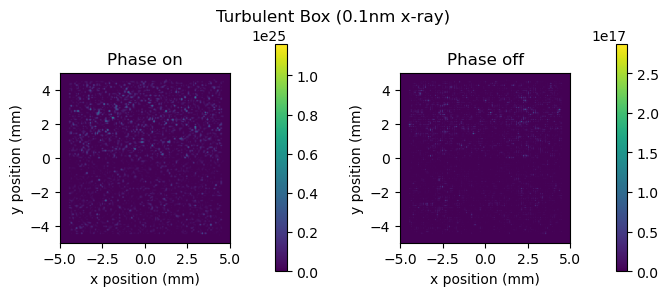

In [11]:
trace_n_plot(suptitle = "Turbulent Box (0.1nm x-ray)", savefig = False, fname = "test1.1")

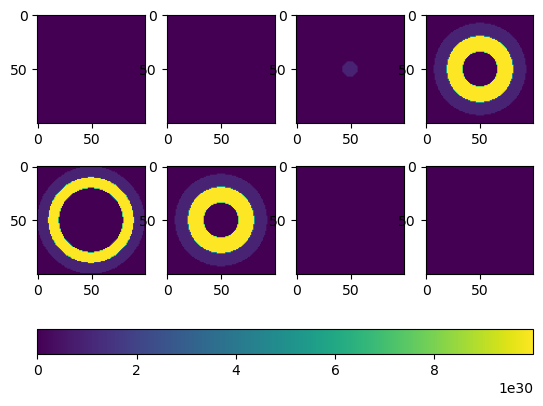

In [13]:
radii = (3e-3, 4e-3, 5e-3)
e_densities = (1e25, 1e31, 1e30)
m_densities = (0.3, 3.5e3, 1.2e5)
ne_sp, rho_sp = sp.spherical(domain, radii, e_densities, m_densities)
fig, axs = plt.subplots(2,4)
norm = colors.Normalize(vmin=np.min(ne_sp), vmax=np.max(ne_sp))
axs = axs.flatten()
images = [0]*8
for i in range(0,8):
    images[i] = axs[i].imshow(ne_sp[:,:,domain.z_n*i//8], norm = norm)
fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)

In [14]:
domain.external_ne(ne_sp)
domain.external_Te(np.full((n_cells, n_cells, n_cells), 2e3))
domain.external_mass_density(None)

jax compilation of solver took: 0.0009958744049072266

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (100000, 2, 9)
	2 to account the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation

We reshape into the form: (9, 100000)

Completed ray trace in 187.265 seconds.
jax compilation of solver took: 0.0009996891021728516

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (100000, 2, 9)
	2 to account the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation

We reshape into the form: (9, 100000)

Completed ray trace in 218.406 seconds.
Fresnel Number: 100000000.0000
Fresnel Number: 100000000.0000


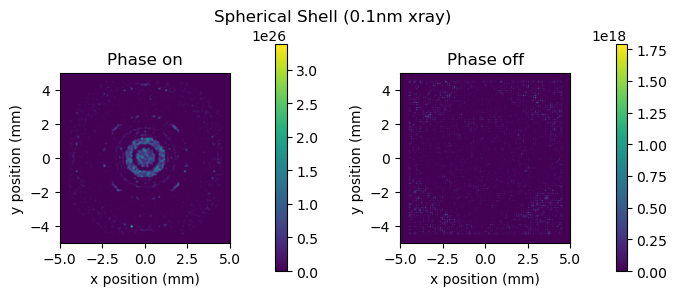

In [16]:
trace_n_plot(suptitle = "Spherical Shell (0.1nm xray)", rho = rho_sp)